# Assignment 1

## EOSC 211

logistics, partner collaboration, due dates

LG's:

* manipulate datetime objects, timedeltas
* use dictionaries to access complex datasets

### notes for andrew:

part 1: I can use if elif else, loops, numpy arrays, logical indexing, annotate, subplots, type casting

part 2: I can use f strings, maybe dictionaries, maybe functions

## Introduction

The ocean in the Salish Sea is affected by tidal forces,  wind, and spatial changes in density,  all of which drive currents.  What do these currents do?  If we release a floating object in the Strait of Georgia (the part of the Salish Sea right beside Vancouver), where will it end up?  Simple questions like turn out to be surprisingly difficult to answer. At present, we do know that there is an “estuarine” circulation in the Salish Sea.  Fresh water flows in from the Fraser River just south of Richmond.  This fresh water eventually ends up in the Pacific*.  So, there is a mean flow of surface water out of the Fraser, south past Victoria and then west out to the Pacific$^†$.  We also know that it takes a few weeks to get there, and so objects floating in the Strait probably also take about that long to leave our waters. But we would like to get a better idea of what the mean speed of their drift is, and how this mean might change from time to time. 

Over the past few years, the [ODL drifters project](www.drifters.eoas.ubc.ca) has been releasing GPS-tracked drifters into the Strait of Georgia near the mouth of the Fraser River, in order to better understand how the surface water flows out to the Pacific. In the assignment, you will analyze some of the data from this project.

---
\* If it didn’t, the whole area would eventually be full of fresh water only, but it isn’t

† We think that very little goes around the northern tip of Vancouver Island because there is only a narrow channel separating it from the mainland there

## Part 0: Scrub the Matlab Data

The following cell is just for dev

In [1]:
## get data (put this in the library when complete)
import numpy as np
from scipy.io import loadmat
from e211_lib import e211
from matplotlib import pyplot as plt

In [2]:
## Hide this cell in library ##

# import the whole dataset
matdata = loadmat("Drifter_dataset.mat")
matdata = matdata["D"].flatten()

##################################################################################
# modify each element one by one, they all have slightly different shapes/dtypes #
##################################################################################

drifter_id = np.concatenate(matdata["id"]).flatten() # drifter ID 

design = np.concatenate(matdata["design"]).flatten() # 1-6 which type of drifter

tzone = np.concatenate(matdata["tzone"]).flatten() # time zone

mtime = matdata["mtime"]  # time in matlab ordinal (decimal days since jan1/0000)
# create a new array datetime to replace messy mtime
datetime = np.empty_like(mtime, dtype="O")
for m in range(len(mtime)):
    timestamp = np.empty(len(mtime[m]), dtype="O")
    for n in range(len(mtime[m].flatten())):
        timestamp[n] = e211.mdate_to_datetime(mtime[m][n,0])
    datetime[m] = timestamp

lon_in = matdata["lon"]  # drifter lons
# create new variable lons containing restructured longitudes
lons = np.empty_like(lon_in, dtype="O")
for m in range(len(lon_in)):
    lon = np.empty(len(lon_in[m]))
    for n in range(len(lon_in[m])):
        lon[n] = lon_in[m][n]
    lons[m] = lon

lat_in = matdata["lat"] # drifter lats
# same treatment for lats
lats = np.empty_like(lat_in, dtype="O")
for m in range(len(lat_in)):
    lat = np.empty(len(lat_in[m]))
    for n in range(len(lat_in[m])):
        lat[n] = lat_in[m][n]
    lats[m] = lat

comment = np.concatenate(matdata["comment"]).flatten()  # metadata

at_sea_in = matdata["atSea"]  # status codes for working/landed drifters

# at_sea treatment echoes lats and lons
at_sea = np.empty_like(at_sea_in, dtype="O")
for m in range(len(at_sea_in)):
    sea = np.empty(len(at_sea_in[m]))
    for n in range(len(at_sea_in[m])):
        sea[n] = at_sea_in[m][n]
    at_sea[m] = sea
    
ends_on_land = matdata["endsOnLand"].flatten() # change from 1/0 logic to Python booleans
ends_on_land[ends_on_land == 1] = True
ends_on_land[ends_on_land == 0] = False

found_on_land = matdata["foundOnLand"].flatten() # use booleans not 1/0
found_on_land[found_on_land == 1] = True
found_on_land[found_on_land == 0] = False

# convert data containing dates to datetime objs
launchdate_in = np.concatenate(matdata["launchDate"]).flatten()
launchdate = np.empty(len(launchdate_in), dtype='O')
for i, ld in enumerate(launchdate_in):
    launchdate[i] = e211.mdate_to_datetime(ld)
        
enddate_in = np.concatenate(matdata["endDate"]).flatten()  
enddate = np.empty(len(enddate_in), dtype = "O")
for i, ed in enumerate(enddate_in):
    enddate[i] = e211.mdate_to_datetime(ed)

lifetime_in = np.concatenate(matdata["lifeTime"]).flatten()  # decimal days from launchDate to endDate
lifetime = enddate - launchdate # ignore the original data and do datetime arithmetic. Get students to do this?

refloated = matdata["refloated"] # change to py logical
refloated[refloated == 1] == True
refloated[refloated == 0] == False

first_ground_date_in = matdata["firstGrndDate"] 
first_ground_date = np.empty(len(first_ground_date_in), dtype='O') 
for i, fgd in enumerate(first_ground_date_in):
    if fgd == 0:
        first_ground_date[i] = enddate[i]
    else:
        first_ground_date[i] = e211.mdate_to_datetime(fgd[0,0])
    
                             # - float: matlab time for first grounding
                             #- matlab time of first of a string of atSea~=1, unless
                             # the last point in the record has atSea==1 and
                             # endsOnLand==1 in which case it is the time of the last
                             # point.

first_lifetime_in = matdata["firstLifeTime"]
first_lifetime = first_ground_date - launchdate # make students do this?

# new datastructure: Each drifter is a dictionary with all vars above as keys, values are either arrays or numbers
# save an array containing all the drifter "objects" (actually dictionaries...) array full of dictionaries full 
# of arrays! 
master_dataset = np.empty(len(drifter_id), dtype='O')
for i, data in enumerate(master_dataset):
     master_dataset[i] =  {"drifter_id":drifter_id[i], 
             "design":design[i], 
             "tzone":tzone[i], 
             "datetime":datetime[i], 
             "lons":lons[i], 
             "lats":lats[i], 
             "comment":comment[i], 
             "at_sea":at_sea[i], 
             "ends_on_land":ends_on_land[i], 
             "found_on_land":found_on_land[i], 
             "launchdate":launchdate[i], 
             "enddate":enddate[i], 
             "lifetime":lifetime[i], 
             "refloated":refloated[i],
             "first_ground_date":first_ground_date[i],
             "first_lifetime":first_lifetime[i]} 
        
# save as a npy file
#np.save("drifter_data.npy", master_dataset)        

## Part 1: Summary Plot

The `drifter_data.npy` file contains all of the data from 153 drifters. The `.npy` extension is a file format specific to numpy arrays. Each element of the array contains a *dictionary* with the following **key:value** pairs:

```
             "drifter_id":        <integer> a unique identifier (e.g., labelled # on drifter body) 
             "design":            <integer> drifter design code (1-6)
             "tzone":             <str> Time zone
             "datetime":          <datetime object> the dates associated with each reported lat/lon position
             "lons":              <float64> longitude in decimal degrees
             "lats":              <float64> latitude in decimal degrees
             "comment":           <str> metadata
             "at_sea":            <int> flag for each point, classifying it as:
                                  1 - good - at sea, freely floating (valid)
                                  2 - bad  - at sea but trapped in rocky intertidal
                                             (floating but not free)
                                  3 - bad  - on land (grounded, test data, etc.)
                                  4 - bad - at sea (large GPS error, on ship, etc.)
             "ends_on_land":      <boolean> if the drifter ends by grounding or not
                                  True - grounded at or just after last at_sea==1 point
                                  False - track ends at sea
             "found_on_land":     <boolean> If the drifter was found by a human (True) on land
                                  or if it was never recovered (False)
             "launchdate":        <datetime object> the date the drifter was launched 
                                  format = (Year, Month, Day, Hour, Minute, Second, Microsecond)
             "enddate":           <datetime object> the date the drifter went offline
             "lifetime":          <timedelta object> the length of the drifter's life
             "refloated":         <boolean> if the drifter went to at_sea != 1 and then resumed 
                                  transmitting with at_sea == 1
             "first_ground_date": <datetime obj> date of first status code != 1
             "first_lifetime":    <timedelta object> length of time passed between launch and first 
                                  status code != 1
```

Note that since all the drifters have different lifetimes, the dataset associated with each drifter will be a different length. Keep this in mind when using loops and indexing to access data, as it may cause errors.

All 153 tracks start in the vicinity of Sand Heads, at the mouth of the Fraser River. These include tracks where the drifter never touches land and eventually dies at sea, and tracks where the drifter grounds. For times between `launchdate` and
`first_ground_date` (or `enddate` if the drifter doesn’t ground), points with `at_sea == 1` are valid points; if any
`at_sea != 1`  then the corresponding `datetime`,`lats` and `lons` points are not valid for various reasons. Sometimes
grounded drifters refloat after some time ashore and drift further, but we will ignore any data that were acquired
after a grounding.

### Your Task

First, write code to show all the drift tracks up until either the point of first grounding, or the end of the track if the drifter does not ground. The track lines should be coloured to indicate the location of the track endpoint:

• Tracks that exit the northern Strait (i.e. with end point west of 125.19◦W, north of 50.0◦N) should be green.


• Tracks that leave the southern Strait (roughly, with end points south of about 48.78◦N latitude, but note that
one track that completely leaves the Strait this way ends up north of this latitude and you should account for
this) should be red.

• Tracks that end within the Strait of Georgia should be light blue.

As well as showing all the tracks, you should also label the starting and end points:

• Label the track starting points with dark blue markers (these should all be near the mouth of the Fraser58
River).

• Label track end points at time of first grounding (if they ground) with green markers.

• Label track end points if the drifter never grounds with red markers.

You should use `if` statements and/or conditional sampling to determine into which category a given track belongs.
Finally, add to the plot a text line that states how many tracks fall into each category - something like

```
100 tracks ground
21 tracks leave the SoG to the south
2 tracks leave the SoG to the north
```

(or whatever the numbers are) To hand in Part 1, provide the code and the plot. It should look something like Figure 1 (with the added text). Note - READ THE REST OF THE ASSIGNMENT so you can see what you have to do for the next part while answering this part. Also, the Handy Tips at the end will be helpful.

In [20]:
data = np.load("drifter_data.npy", allow_pickle=True)
basemap = loadmat("SouthVI.mat")

basemap["SouthVI"][0]

array([(array([[-128.        , -127.96606822, -127.93213645, -127.89820467,
               -127.8642729 , -127.83034112, -127.79640935, -127.76247757,
               -127.7285458 , -127.69461402, -127.66068225, -127.62675047,
               -127.5928187 , -127.55888692, -127.52495515, -127.49102337,
               -127.4570916 , -127.42315982, -127.38922805, -127.35529627,
               -127.32136449, -127.28743272, -127.25350094, -127.21956917,
               -127.18563739, -127.15170562, -127.11777384, -127.08384207,
               -127.04991029, -127.01597852, -126.98204674, -126.94811497,
               -126.91418319, -126.88025142, -126.84631964, -126.81238787,
               -126.77845609, -126.74452432, -126.71059254, -126.67666076,
               -126.64272899, -126.60879721, -126.57486544, -126.54093366,
               -126.50700189, -126.47307011, -126.43913834, -126.40520656,
               -126.37127479, -126.33734301, -126.30341124, -126.26947946,
               -126.2355

In [16]:
basemap["ncst"].shape
baselon = basemap["ncst"][:,0]
baselat = basemap["ncst"][:,1]

contour = basemap["k"].shape

contour

(634, 1)

TypeError: Input z must be 2D, not 1D

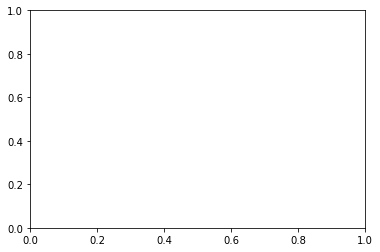

In [7]:
fig, ax = plt.subplots()
ax.contourf(baselon, baselat)
#for n, data in enumerate(master_dataset):
#    ax.plot(master_dataset[n]["lons"], master_dataset[n]["lats"])